# 5. Function fitting and Interpolation

In today's session, we will be using some of the LAI datasets we examined last week (masked by national boundaries) and doing some analysis on them.

- [5.1 Making 3D datasets and Movies](#5.1-Making-3D-datasets-and-Movies)
    First, we will examine how to improve our data reading function by extracting only the area we are interested in. This involves querying the 'country' mask to find its limits and passing this information through to the reader.

- [5.2 Interpolation](#5.2-Interpolation)
    Then we will look at methods to interpolate and smooth over gaps in datasets using various methods.

- [5.3 Function Fitting](#5.3-Function-fitting)
    Finally, we will look at fitting models to datasets, in this case a model describing LAI phenology.

## 5.1 Making 3D datasets and Movies

First though, we will briefly go over once more the work we did on downloading data (ussssing `wget`), generating 3D masked datasets, and making movies.

This time, we will concentrate more on generating functions that we can re-use for other purposes.

### 5.1.1 Downloading data

We start by filtering the file `data/robot.txt` to get only lines (containing urls) for a particular tile and year.

We might easily do this in unix:

In [1]:
%%bash

# filter LAI MODIS files for this year and tile (in bash)
tile='h17v03'
year='2005'
ofile=data/modis_lai_${tile}_${year}.txt

grep $tile < data/robot.txt | grep \/$year > $ofile

# have a look at the first few
head -4 < $ofile

http://e4ftl01.cr.usgs.gov/MODIS_Composites/MOTA/MCD15A2.005/2005.01.01/MCD15A2.A2005001.h17v03.005.2007350235547.hdf
http://e4ftl01.cr.usgs.gov/MODIS_Composites/MOTA/MCD15A2.005/2005.01.09/MCD15A2.A2005009.h17v03.005.2007351235445.hdf
http://e4ftl01.cr.usgs.gov/MODIS_Composites/MOTA/MCD15A2.005/2005.01.17/MCD15A2.A2005017.h17v03.005.2007352033411.hdf
http://e4ftl01.cr.usgs.gov/MODIS_Composites/MOTA/MCD15A2.005/2005.01.25/MCD15A2.A2005025.h17v03.005.2007353055037.hdf


Now download the datasets:

In [2]:
%%bash

tile='h17v03'
year='2005'
ofile=data/modis_lai_${tile}_${year}.txt

# go into the directory we want the data
pushd data
# get the urls from the file 
# --cut-dirs=4 this time as there are 4 laters of directory we
# wish to ignore with this dataset
wget --quiet -nc -nH --cut-dirs=4 -i ../$ofile
# go back to where we were
popd

/archive/rsu_raid_0/plewis/public_html/geogg122_current/Chapter5_Interpolation/data /archive/rsu_raid_0/plewis/public_html/geogg122_current/Chapter5_Interpolation
/archive/rsu_raid_0/plewis/public_html/geogg122_current/Chapter5_Interpolation


### 5.1.2 Read from an ASCII file

The ASCII file `data/modis_lai_${tile}_${year}.txt` contains lines of urls. 

Each line (each url) is a string such as:

`http://e4ftl01.cr.usgs.gov/MODIS_Composites/MOTA/MCD15A2.005/2005.01.25/MCD15A2.A2005025.h17v03.005.2007353055037.hdf`

The *filename* here is `MCD15A2.A2005025.h17v03.005.2007353055037.hdf`, so we can split the url on the field `/` to get this:

Let's read the filenames from the text file that has the urls in it and load it into a list that we will call `filelist`:

In [3]:
import numpy as np

tile = 'h17v03'
year = '2005'

# specify the file with the urls in
ifile= 'data/modis_lai_%s_%s.txt'%(tile,year)

# one way to read the data from the file
fp = open(ifile)
lines = fp.readlines()
filelist = []
for url in lines:
    filename = url.split('/')[-1].strip()
    filelist.append(filename)
fp.close()

# show the first few
print filelist[:5]

['MCD15A2.A2005001.h17v03.005.2007350235547.hdf', 'MCD15A2.A2005009.h17v03.005.2007351235445.hdf', 'MCD15A2.A2005017.h17v03.005.2007352033411.hdf', 'MCD15A2.A2005025.h17v03.005.2007353055037.hdf', 'MCD15A2.A2005033.h17v03.005.2007355050158.hdf']


In [4]:
# a neater way:
fp = open(ifile)
filelist = [url.split('/')[-1].strip() for url in fp.readlines()]
fp.close()

# show the first few
print filelist[:5]

['MCD15A2.A2005001.h17v03.005.2007350235547.hdf', 'MCD15A2.A2005009.h17v03.005.2007351235445.hdf', 'MCD15A2.A2005017.h17v03.005.2007352033411.hdf', 'MCD15A2.A2005025.h17v03.005.2007353055037.hdf', 'MCD15A2.A2005033.h17v03.005.2007355050158.hdf']


In [5]:
# an even neater way using np.loadtxt
# But don't worry if you don't quite get this one yet!

# define a function get_filename(f)
# When a function is 'small' its easier to use a lambda definition!
get_filename = lambda f: f.split('/')[-1]
filelist = np.loadtxt(ifile,dtype='str',converters={0:get_filename})

print filelist[:5]

['MCD15A2.A2005001.h17v03.005.2007350235547.hdf'
 'MCD15A2.A2005009.h17v03.005.2007351235445.hdf'
 'MCD15A2.A2005017.h17v03.005.2007352033411.hdf'
 'MCD15A2.A2005025.h17v03.005.2007353055037.hdf'
 'MCD15A2.A2005033.h17v03.005.2007355050158.hdf']


### 5.1.3 Read Just The Data We Want

Last time, we generated a function to read MODIS LAI data.

We have now included such a function in the directory [`files/python`](files/python) called [`get_lai.py`](files/python/get_lai.py).

The only added sophistication is that when we call `ReadAsArray`, we give it the starting cols, rows, and number of cols and rows to read (e.g. `xsize=600,yoff=300,xoff=300,ysize=600`):

In [6]:
# Now we have a list of filenames
# load read_lai
import sys
sys.path.insert(0,'python')

from get_lai import get_lai

help(get_lai)

Help on function get_lai in module get_lai:

get_lai(filename, qc_layer='FparLai_QC', scale=[0.1, 0.1], mincol=0, minrow=0, ncol=None, nrow=None, selected_layers=['Lai_1km', 'LaiStdDev_1km'])



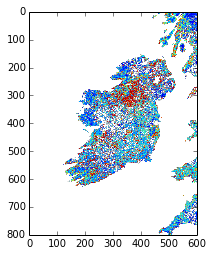

In [7]:
# e.g. for reading a single file:

lai_file0 = get_lai('data/%s'%filelist[20],ncol=600,mincol=300,minrow=400,nrow=800)
plt.imshow(lai_file0['Lai_1km'])

In [8]:
print type(lai_file0)
print lai_file0.keys()

<type 'dict'>
['Lai_1km', 'LaiStdDev_1km']


The function returns a dictionary with has keys `['Lai_1km', 'LaiStdDev_1km', 'FparLai_QC']`:

In [9]:
print lai_file0['Lai_1km'].shape

(800, 600)


Each of these datasets is of shape `(1200, 1200)`, but we have read only 600 (columns) and 800 (rows) in this case. Note that the numpy indexing is `(rows,cols)`.

We know how to create a mask from a vector dataset from thelast session:

<matplotlib.colorbar.Colorbar instance at 0x7efff3f65b48>

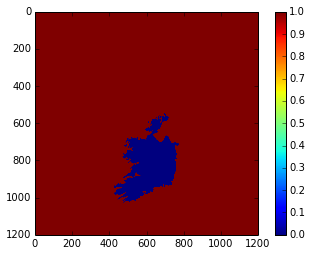

In [10]:
# have to make sure have access to gdal data files 
import os
if 'GDAL_DATA' not in os.environ:
    os.environ["GDAL_DATA"] = '/opt/anaconda/share/gdal'

from raster_mask import raster_mask

# make a raster mask
# from the layer IRELAND in world.shp
filename = filelist[0]
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
file_spec = file_template%('data/%s'%filename,'Lai_1km')
                           
mask = raster_mask(file_spec,\
                   target_vector_file = "data/world.shp",\
                   attribute_filter = "NAME = 'IRELAND'")


plt.imshow(mask)
plt.colorbar()

In this case, the data we want is only a small section of the whole spatial dataset.

It would be convenient to extract *only* the part we want.

We can use `numpy.where()` to help with this:

In [11]:
# The mask is False for the area we want
rowpix,colpix = np.where(mask == False)

print rowpix,colpix

[ 548  548  548 ..., 1024 1025 1025] [693 694 695 ..., 476 473 474]


`rowpix` and `colpix` are lists of pixel coordinates where the condition we specified is `True` (i.e. where `mask` is `False`).

If we wanted to find the bounds of this area, we simply need to know the minimum and maximum column and row in these lists:

In [12]:
mincol,maxcol = min(colpix),max(colpix)
minrow,maxrow = min(rowpix),max(rowpix)

# think about why the + 1 here!!!
# what if maxcol and mincol were the same?
ncol = maxcol - mincol + 1
nrow = maxrow - minrow + 1

print minrow,mincol,nrow,ncol

548 422 478 348


We could use this information to extract *only* the area we want when we read the data:

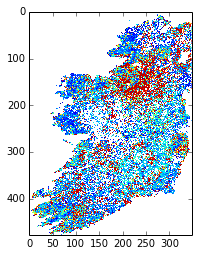

In [13]:
lai_file0 = get_lai('data/%s'%filelist[20],\
                    ncol=ncol,nrow=nrow,mincol=mincol,minrow=minrow)

plt.imshow(lai_file0['Lai_1km'],interpolation='none')

Now, lets extract this portion of the mask:

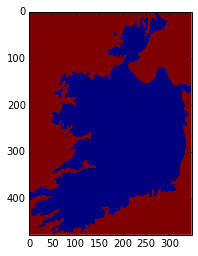

In [14]:
small_mask = mask[minrow:minrow+nrow,mincol:mincol+ncol]

plt.imshow(small_mask,interpolation='none')

And combine the country mask with the small dataset:

As a recap, we can use the function `raster_mask` that we gave you last time to develop a raster mask (!) from an ESRI shapefile (`data/world.shp` here).

We can then combine this mask with the QC-derived mask in the LAI dataset.

The LAI mask (that will be `lai.mask` in the code below) is `False` for good data, as is the coutry mask.

To combine them, we want some operator `X` for which:

`True  X True  == True`  
`True  X False == True`  
`False X True  == True`  
`False X False == False`  

The operator to use then is an *or*, here, a bitwise or, `|`.


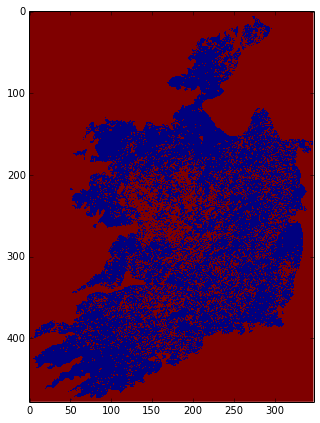

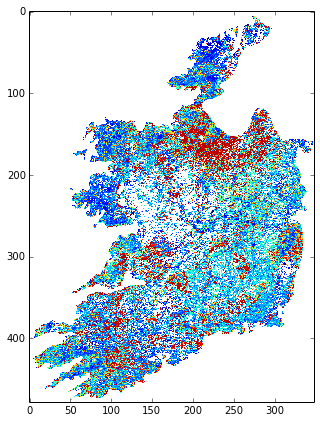

In [15]:
lai_file0 = get_lai('data/%s'%filelist[20],\
                    ncol=ncol,nrow=nrow,mincol=mincol,minrow=minrow)

layer = 'Lai_1km'
lai = lai_file0[layer]
small_mask = mask[minrow:minrow+nrow,mincol:mincol+ncol]

# combined mask
new_mask = small_mask | lai.mask

plt.figure(figsize=(7,7))
plt.imshow(new_mask,interpolation='none')

lai = ma.array(lai,mask=new_mask)

plt.figure(figsize=(7,7))
plt.imshow(lai,interpolation='none')


We should be used to writing loops around such functions.

In this case, we read *all* of the files in `filelist` and put the data into the dictionary called `lai` here.

Because there are multiple layers in the datasets, we loop over layer and append to each list indiviually:

In [16]:
# load 'em all ...

# for United Kingdom here

import numpy.ma as ma
from raster_mask import raster_mask

country = 'UNITED KINGDOM'

# make a raster mask
# from the layer UNITED KINGDOM in world.shp
filename = filelist[0]
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
file_spec = file_template%('data/%s'%filename,'Lai_1km')
                           
mask = raster_mask(file_spec,\
                   target_vector_file = "data/world.shp",\
                   attribute_filter = "NAME = '%s'"%country)
# extract just the area we want
# by getting the min/max rows/cols
# of the data mask
# The mask is False for the area we want
rowpix,colpix = np.where(mask == False)
mincol,maxcol = min(colpix),max(colpix)
minrow,maxrow = min(rowpix),max(rowpix)
ncol = maxcol - mincol + 1
nrow = maxrow - minrow + 1
# and make a small mask
small_mask = mask[minrow:minrow+nrow,mincol:mincol+ncol]


# data_fields with empty lists
data_fields = {'LaiStdDev_1km':[],'Lai_1km':[]}

# make a dictionary and put the filenames in it
# along with the mask and min/max info
lai = {'filenames':np.sort(filelist),\
       'minrow':minrow,'mincol':mincol,\
       'mask':small_mask}

# combine the dictionaries
lai.update(data_fields)

# loop over each filename
for f in np.sort(lai['filenames']):
    this_lai = get_lai('data/%s'%f,\
                       mincol=mincol,ncol=ncol,\
                       minrow=minrow,nrow=nrow)
    for layer in data_fields.keys():
        # apply the mask
        new_mask = this_lai[layer].mask | small_mask
        this_lai[layer] = ma.array(this_lai[layer],mask=new_mask)
        lai[layer].append(this_lai[layer])
        

(1200, 566)
2005161


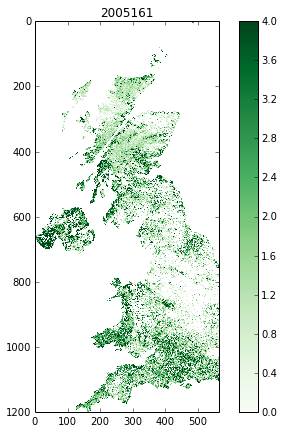

In [17]:
# have a look at one of these

i = 20

import pylab as plt

# just see what the shape is ...
print lai['Lai_1km'][i].shape

root = 'images/lai_uk'

cmap = plt.cm.Greens

f = lai['filenames'][i]
fig = plt.figure(figsize=(7,7))
# get some info from filename
file_id = f.split('/')[-1].split('.')[-5][1:]
print file_id
plt.imshow(lai['Lai_1km'][i],cmap=cmap,interpolation='none',vmax=4.,vmin=0.0)
# plot a jpg
plt.title(file_id)
plt.colorbar()
plt.savefig('images/lai_uk_%s.jpg'%file_id)

In [18]:
# thats quite good, so put as a function:
import numpy.ma as ma
import numpy as np
import sys
sys.path.insert(0,'python')
from get_lai import get_lai
from raster_mask import raster_mask


def read_lai(filelist,datadir='data',country=None):
    '''
    Read MODIS LAI data from a set of files
    in the list filelist. Data assumed to be in
    directory datadir.
    
    Parameters:
    filelist : list of LAI files
    
    Options:
    datadir  : data directory
    country  : country name (in data/world.shp)
    
    Returns:
    lai dictionary
    '''
    if country:
        # make a raster mask
        # from the layer UNITED KINGDOM in world.shp
        file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
        file_spec = file_template%('data/%s'%filelist[0],'Lai_1km')
                                   
        mask = raster_mask(file_spec,\
                           target_vector_file = "data/world.shp",\
                           attribute_filter = "NAME = '%s'"%country)
        # extract just the area we want
        # by getting the min/max rows/cols
        # of the data mask
        # The mask is False for the area we want
        rowpix,colpix = np.where(mask == False)
        mincol,maxcol = min(colpix),max(colpix)
        minrow,maxrow = min(rowpix),max(rowpix)
        ncol = maxcol - mincol + 1
        nrow = maxrow - minrow + 1
        # and make a small mask
        small_mask = mask[minrow:minrow+nrow,mincol:mincol+ncol]
    else:
        # no country
        mincol = 0
        maxcol = 0
        ncol = None
        nrow = None

    # data_fields with empty lists
    data_fields = {'LaiStdDev_1km':[],'Lai_1km':[]}
    
    # make a dictionary and put the filenames in it
    # along with the mask and min/max info
    lai = {'filenames':np.sort(filelist),\
           'minrow':minrow,'mincol':mincol,\
           'mask':small_mask}
    
    # combine the dictionaries
    lai.update(data_fields)
    
    # loop over each filename
    for f in np.sort(lai['filenames']):
        this_lai = get_lai('data/%s'%f,\
                           mincol=mincol,ncol=ncol,\
                           minrow=minrow,nrow=nrow)
        for layer in data_fields.keys():
            # apply the mask
            if country:
                new_mask = this_lai[layer].mask | small_mask
                this_lai[layer] = ma.array(this_lai[layer],mask=new_mask)
            lai[layer].append(this_lai[layer])   
    for layer in data_fields.keys():
        lai[layer] = ma.array(lai[layer])
            
    return lai

creating mask of IRELAND
... MCD15A2.A2005001.h17v03.005.2007350235547.hdf
... MCD15A2.A2005009.h17v03.005.2007351235445.hdf
... MCD15A2.A2005017.h17v03.005.2007352033411.hdf
... MCD15A2.A2005025.h17v03.005.2007353055037.hdf
... MCD15A2.A2005033.h17v03.005.2007355050158.hdf
... MCD15A2.A2005041.h17v03.005.2007357014602.hdf
... MCD15A2.A2005049.h17v03.005.2007360165724.hdf
... MCD15A2.A2005057.h17v03.005.2007361230641.hdf
... MCD15A2.A2005065.h17v03.005.2007365024202.hdf
... MCD15A2.A2005073.h17v03.005.2008001043631.hdf
... MCD15A2.A2005081.h17v03.005.2008003173048.hdf
... MCD15A2.A2005089.h17v03.005.2008005154542.hdf
... MCD15A2.A2005097.h17v03.005.2008007175837.hdf
... MCD15A2.A2005105.h17v03.005.2008018085544.hdf
... MCD15A2.A2005113.h17v03.005.2008021020137.hdf
... MCD15A2.A2005121.h17v03.005.2008021193749.hdf
... MCD15A2.A2005129.h17v03.005.2008024061330.hdf
... MCD15A2.A2005137.h17v03.005.2008032075236.hdf
... MCD15A2.A2005145.h17v03.005.2008033192556.hdf
... MCD15A2.A2005153.h17v

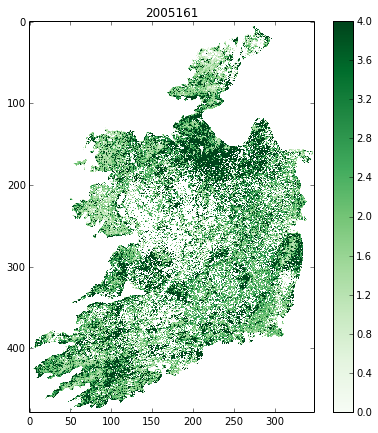

In [19]:
# test this ... the one in the file
# does a cutout of the data area as well
# which will keep the memory
# requirements down
from get_lai import read_lai

lai = read_lai(filelist,country='IRELAND',verbose=True)

# have a look at one of these

i = 20

# just see what the shape is ...
print lai['Lai_1km'][i].shape

root = 'images/lai_eire'

cmap = plt.cm.Greens

f = lai['filenames'][i]
fig = plt.figure(figsize=(7,7))
# get some info from filename
file_id = f.split('/')[-1].split('.')[-5][1:]
print file_id
plt.imshow(lai['Lai_1km'][i],cmap=cmap,interpolation='none',vmax=4.,vmin=0.0)
# plot a jpg
plt.title(file_id)
plt.colorbar()
plt.savefig('%s_%s.jpg'%(root,file_id))

In [20]:
# make a movie

import pylab as plt
import os

# just see what the shape is ...
print lai['Lai_1km'].shape

root = 'images/lai_country_eire'

cmap = plt.cm.Greens

for i,f in enumerate(lai['filenames']):
    fig = plt.figure(figsize=(7,7))
    # get some info from filename
    file_id = f.split('/')[-1].split('.')[-5][1:]
    print file_id
    plt.imshow(lai['Lai_1km'][i],cmap=cmap,interpolation='none',vmax=4.,vmin=0.0)
    # plot a jpg
    plt.title(file_id)
    plt.colorbar()
    plt.savefig('%s_%s.jpg'%(root,file_id))
    plt.close(fig)
    
cmd = 'convert -delay 100 -loop 0 {0}_*.jpg {0}_movie.gif'.format(root)
os.system(cmd)

(46, 478, 348)
2005001
2005009
2005017
2005025
2005033
2005041
2005049
2005057
2005065
2005073
2005081
2005089
2005097
2005105
2005113
2005121
2005129
2005137
2005145
2005153
2005161
2005169
2005177
2005185
2005193
2005201
2005209
2005217
2005225
2005233
2005241
2005249
2005257
2005265
2005273
2005281
2005289
2005297
2005305
2005313
2005321
2005329
2005337
2005345
2005353
2005361


0

![](files/images/lai_country_eire_movie.gif)

In [21]:
# The movie making works, so pack that into a function

import pylab as plt
import os

root = 'images/lai_eire'

def make_movie(lai,root,layer='Lai_1km',vmax=4.,vmin=0.,do_plot=False):
    '''
    Make an animated gif from MODIS LAI data in
    dictionary 'lai'.
    
    Parameters:
    lai    : data dictionary
    root   : root file /directory name of frames and movie
    
    layer  : data layer to plot 
    vmax   : max value for plotting
    vmin   : min value for plotting
    do_plot: set True if you want the individual plots
             to display
    
    Returns:
    movie name    
    
    '''
    cmap = plt.cm.Greens
    
    for i,f in enumerate(lai['filenames']):
        fig = plt.figure(figsize=(7,7))
        # get some info from filename
        file_id = f.split('/')[-1].split('.')[-5][1:]
        print file_id
        plt.imshow(lai[layer][i],cmap=cmap,interpolation='none',\
                   vmax=vmax,vmin=vmin)
        # plot a jpg
        plt.title(file_id)
        plt.colorbar()
        plt.savefig('%s_%s.jpg'%(root,file_id))
        if not do_plot:
            plt.close(fig)
        
    cmd = 'convert -delay 100 -loop 0 {0}_*.jpg {0}_movie.gif'.format(root)
    os.system(cmd)
    return '{0}_movie.gif'.format(root)

In [22]:
# test it

lai_uk = read_lai(filelist,country='UNITED KINGDOM')
root = 'images/lai_UK'
movie = make_movie(lai_uk,root)
print movie

2005001
2005009
2005017
2005025
2005033
2005041
2005049
2005057
2005065
2005073
2005081
2005089
2005097
2005105
2005113
2005121
2005129
2005137
2005145
2005153
2005161
2005169
2005177
2005185
2005193
2005201
2005209
2005217
2005225
2005233
2005241
2005249
2005257
2005265
2005273
2005281
2005289
2005297
2005305
2005313
2005321
2005329
2005337
2005345
2005353
2005361
images/lai_UK_movie.gif


![](files/images/lai_UK_movie.gif)

## 5.2 Interpolation

### 5.2.1 Univariate interpolation

So, we can load the data we want from multiple MODIS hdf files that we have downloaded from the NASA server into a 3D masked numpy array, with a country boundary mask (projected int the raster data coordinate system) from a vector dataset.

Let's start to explore the data then.

You should have an array of LAI for Ireland:

In [23]:
type(lai['Lai_1km'])

numpy.ma.core.MaskedArray

Let's plot the LAI for some given pixels.

First, we might like to identify which pixels actually have any data.

A convenient function for this would be `np.where` that returns the indices of items that are `True`.

Since the data mask is `False` for good data, we take the complement `~` so that good data are `True:

In [24]:
data = lai['Lai_1km']
np.where(~data.mask)

(array([ 3,  3,  3, ..., 39, 39, 39]),
 array([326, 328, 329, ..., 472, 472, 475]),
 array([ 82, 145,  83, ...,  86,  87,  51]))

An example good pixel this is (3,329,145). Let's look at this for all time periods:

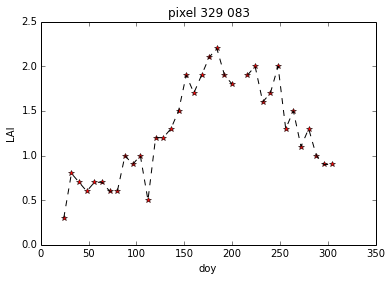

In [25]:
data = lai['Lai_1km']

r = 329
c = 83

pixel = data[:,r,c]

# plot red stars at the data points
plt.plot(np.arange(len(pixel))*8,pixel,'r*')
# plot a black (k) dashed line (--)
plt.plot(np.arange(len(pixel))*8,pixel,'k--')
plt.xlabel('doy')
plt.ylabel('LAI')
plt.title('pixel %03d %03d'%(r,c))

The data follow the trend of what we might expect for LAI development, but they are clearly a little noisy.

We also have access to uncertainty information (standard deviation):

/opt/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3847: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


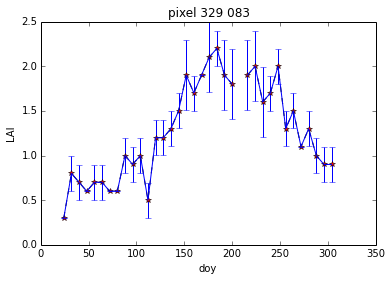

In [26]:
# copy the data in case we change it any

data = lai['Lai_1km'].copy()
sd   = lai['LaiStdDev_1km'].copy()

r = 329
c = 83

pixel    = data[:,r,c]
pixel_sd =   sd[:,r,c]

x = np.arange(len(pixel))*8

# plot red stars at the data points
plt.plot(x,pixel,'r*')
# plot a black (k) dashed line (--)
plt.plot(x,pixel,'k--')
# plot error bars:
# 1.96 because that is the 95% confidence interval
plt.errorbar(x,pixel,yerr=pixel_sd*1.96)
plt.xlabel('doy')
plt.ylabel('LAI')
plt.title('pixel %03d %03d'%(r,c))

We would generally expect LAI to be quite smoothly varying over time. Visualising the data with 95% confidence intervals is quite useful as we can now 'imagine' some smooth line that would generally go within these bounds.

Some of the uncertainty estimates are really rather small though, which are probably not reliable.

Let's inflate them:



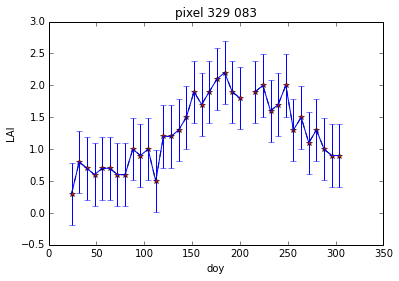

In [27]:

data = lai['Lai_1km'].copy()
sd   = lai['LaiStdDev_1km'].copy()

r = 329
c = 83

pixel    = data[:,r,c]
pixel_sd =   sd[:,r,c]
# threshold
thresh = 0.25
pixel_sd[pixel_sd<thresh] = thresh

x = np.arange(len(pixel))*8

# plot red stars at the data points
plt.plot(x,pixel,'r*')
# plot a black (k) dashed line (--)
plt.plot(x,pixel,'k--')
# plot error bars:
# 1.96 because that is the 95% confidence interval
plt.errorbar(x,pixel,yerr=pixel_sd*1.96)
plt.xlabel('doy')
plt.ylabel('LAI')
plt.title('pixel %03d %03d'%(r,c))

This is perhaps a bit more realistic ...

The data now have some missing values (data gaps) and, as we have noted, are a little noisy.

A Python module we can use for many scientific functions is [`scipy`](http://docs.scipy.org/doc/scipy), in particular here, the [`scipy` interpolation functions](http://docs.scipy.org/doc/scipy/reference/interpolate.html).

We need to make a careful choice of the interpolation functions.

We might, in many circumstances simply want something that interpolates between data points, i.e. that goes through the data points that we have.

Many interpolators will not provide extrapolation, so in the example above we could not get an estimate of LAI prior to the first sample and after the last.

The best way to deal with that would be to have multiple years of data.

Instead here, we will repeat the dataset three times to mimic this:


In [28]:
from scipy import interpolate

pixel = data[:,r,c]

# original x,y
y_ = pixel
x_ = (np.arange(len(y_))*8.+1)[~pixel.mask]
y_ = y_[~pixel.mask]

# extend: using np.tile() to repeat data
y_extend = np.tile(y_,3)
# extend: using vstack to stack 3 different arrays
x_extend = np.hstack((x_-46*8,x_,x_+46*8))

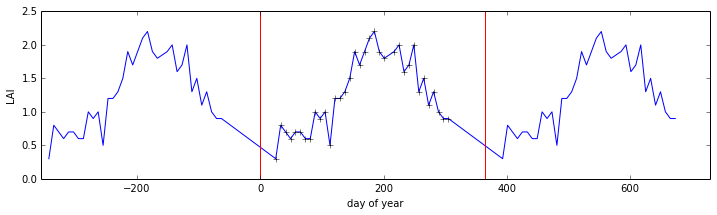

In [29]:
# plot the extended dataset
plt.figure(figsize=(12,3))
plt.plot(x_extend,y_extend,'b')
plt.plot(x_,y_,'k+')
plt.plot([0.,0.],[0.,2.5],'r')
plt.plot([365.,365.],[0.,2.5],'r')
plt.xlim(-356,2*365)
plt.xlabel('day of year')
plt.ylabel('LAI')

In [30]:
# define xnew at 1 day interval
xnew = np.arange(1.,366.)

# linear interpolation
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
ynew = f(xnew)

(1, 366)

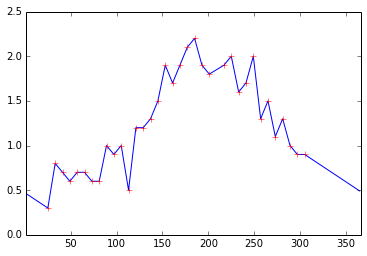

In [31]:
plt.plot(xnew,ynew)
plt.plot(x_,y_,'r+')
plt.xlim(1,366)

(1, 366)

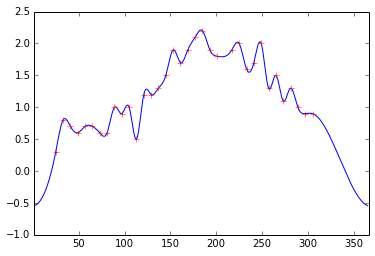

In [32]:
# cubic interpolation
f = interpolate.interp1d(x_extend,y_extend,kind='cubic')
ynew = f(xnew)
plt.plot(xnew,ynew)
plt.plot(x_,y_,'r+')
plt.xlim(1,366)

(1, 366)

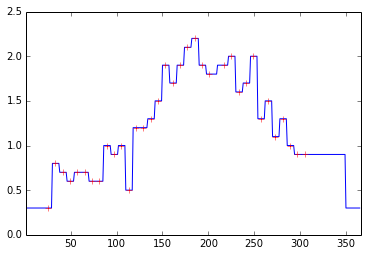

In [33]:
# nearest neighbour interpolation
f = interpolate.interp1d(x_extend,y_extend,kind='nearest')
ynew = f(xnew)
plt.plot(xnew,ynew)
plt.plot(x_,y_,'r+')
plt.xlim(1,366)

Depending on the problem you are trying to solve, different interpolation schemes will be appropriate. For categorical data (e.g. 'snow', coded as 1 and 'no snow' coded as 1), for instance, a nearest neighbour interpolation might be a good idea.

### 5.2.2 Smoothing

One issue with the schemes above is that they go exactly through the data points, but a more realistic description of the data might be one that incorporated the uncertainty information we have. Visually, this is quite easy to imagine, but how can we implement such ideas?

One way of thinking about this is to think about other sources of information that we might bring to bear on the problem. One such would be that we expect the function to be 'quite smooth'. This allows us to consider applying smoothness as an additional constraint to the solution.

Many such problems can be phrased as convolution operations.

Convolution is a form of digital filtering that combines two sequences of numbers $y$ and $w$ to give a third, the result $z$ that is a filtered version of $y$, where for each element $j$ of $y$:

$$
  z_j = \sum_{i=-n}^{i=n}{w_i y_{j+i}}
$$

where $n$ is the half width of the filter $w$. For a smoothing filter, the elements of this will sum to 1 (so that the magnitude of $y$ is not changed).

To illustrate this in Python:



In [34]:
# a simple box smoothing filter
# filter width 11
w = np.ones(11)
# normalise
w = w/w.sum()
# half width
n = len(w)/2

# Take the linear interpolation of the LAI above as the signal 
# linear interpolation
x = xnew
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
y = f(x)

# where we will put the result
z = np.zeros_like(y)

# This is a straight implementation of the
# equation above
for j in xrange(n,len(y)-n):
    for i in xrange(-n,n+1):
        z[j] += w[n+i] * y[j+i]

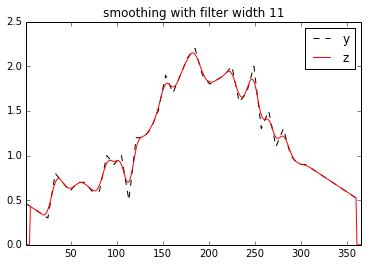

In [35]:
plt.plot(x,y,'k--',label='y')
plt.plot(x,z,'r',label='z')
plt.xlim(x[0],x[-1])
plt.legend(loc='best')
plt.title('smoothing with filter width %d'%len(w))

As we suggested, the result of convolving $y$ with the filter $w$ (of width 31 here) is $z$, a smoothed version of $y$.

You might notice that the filter is only applied once we are `n` samples into the signal, so we get 'edge effects'. There are various ways of dealing with edge effects, such as repeating the signal (as we did above, for much the same reason), reflecting the signal, or assuming the signal to be some constant value (e.g. 0) outside of its defined domain.

If we make the filter wider (width 31 now):

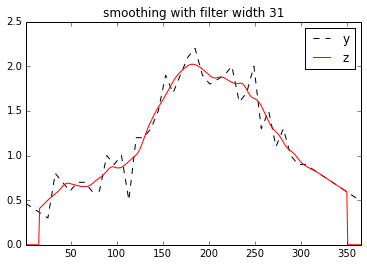

In [36]:
# a simple box smoothing filter
# filter width 31
w = np.ones(31)
# normalise
w = w/w.sum()
# half width
n = len(w)/2

# Take the linear interpolation of the LAI above as the signal 
# linear interpolation
x = xnew
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
y = f(x)

# where we will put the result
z = np.zeros_like(y)

# This is a straight implementation of the
# equation above
for j in xrange(n,len(y)-n):
    for i in xrange(-n,n+1):
        z[j] += w[n+i] * y[j+i]
        
plt.plot(x,y,'k--',label='y')
plt.plot(x,z,'r',label='z')
plt.xlim(x[0],x[-1])
plt.legend(loc='best')
plt.title('smoothing with filter width %d'%len(w))

Then the signal is 'more' smoothed. 

There are *many* filters implemented in [`scipy.signal`](http://docs.scipy.org/doc/scipy/reference/signal.html) that you should look over.

A very commonly used smoothing filter is the [Savitsky-Golay](http://en.wikipedia.org/wiki/Savitzky–Golay_filter_for_smoothing_and_differentiation) filter for which you define the window size and filter order.

As with most filters, the filter width controls the degree of smoothing (see examples above). The filter order (related to polynomial order) in essence controls the shape of the filter and defines the 'peakiness' of the response.

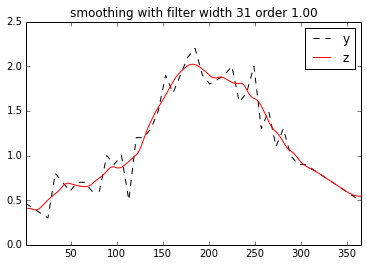

In [37]:
import sys
sys.path.insert(0,'python')
# see http://wiki.scipy.org/Cookbook/SavitzkyGolay
from savitzky_golay import *

window_size = 31
order = 1

# Take the linear interpolation of the LAI above as the signal 
# linear interpolation
x = xnew
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
y = f(x)

z = savitzky_golay(y,window_size,order)

plt.plot(x,y,'k--',label='y')
plt.plot(x,z,'r',label='z')
plt.xlim(x[0],x[-1])
plt.legend(loc='best')
plt.title('smoothing with filter width %d order %.2f'%(window_size,order))

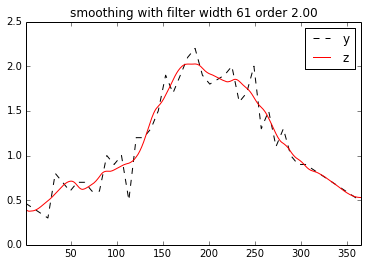

In [38]:
import sys
sys.path.insert(0,'python')
# see http://wiki.scipy.org/Cookbook/SavitzkyGolay
from savitzky_golay import *

window_size = 61
order = 2

# Take the linear interpolation of the LAI above as the signal 
# linear interpolation
x = xnew
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
y = f(x)

z = savitzky_golay(y,window_size,order)

plt.plot(x,y,'k--',label='y')
plt.plot(x,z,'r',label='z')
plt.xlim(x[0],x[-1])
plt.legend(loc='best')
plt.title('smoothing with filter width %d order %.2f'%(window_size,order))

If the samples $y$ have uncertainty (standard deviation $\sigma_j$ for sample $j$) associated with them, we can incorporate this into smoothing, although many of the methods in `scipy` and `numpy` do not directly allow for this.

Instead, we call an optimal interpolation scheme (a regulariser) here that achieves this. This also has the advantage of giving an estimate of uncertainty for the smoothed samples.

In this case, the parameters are: `order` (as above, but only integer in this implementation) and `wsd` which is an estimate of the variation (standard deviation) in the signal that control smoothness.

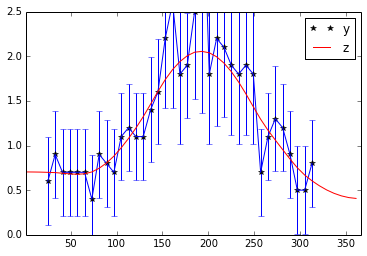

In [40]:
tile = 'h17v03'
year = '2005'

# specify the file with the urls in
ifile= 'data/modis_lai_%s_%s.txt'%(tile,year)

fp = open(ifile)
filelist = [url.split('/')[-1].strip() for url in fp.readlines()]
fp.close()
import sys
sys.path.insert(0,'files/python')

from get_lai import *

try:
    data = lai['Lai_1km']
    sd = lai['LaiStdDev_1km']
except:
    lai = read_lai(filelist,country='IRELAND')
    data = lai['Lai_1km']
    sd = lai['LaiStdDev_1km']
    
thresh = 0.25
sd[sd<thresh] = thresh

r = 472
c = 84
from smoothn import *

# this is about the right amount of smoothing here
gamma = 5.

pixel = data[:,r,c]
pixel_sd =   sd[:,r,c]

x = np.arange(46)*8+1

order = 2
z = smoothn(pixel,s=gamma,sd=pixel_sd,smoothOrder=2.0)[0]

# plot
plt.plot(x,pixel,'k*',label='y')
plt.errorbar(x,pixel,pixel_sd*1.96)
plt.plot(x,z,'r',label='z')
# lower and upper bounds of 95% CI

plt.xlim(1,366)
plt.ylim(0.,2.5)
plt.legend(loc='best')

1

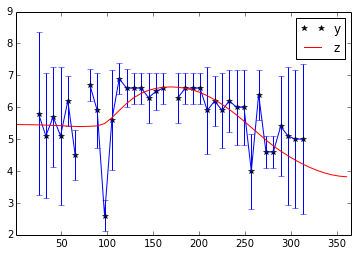

In [41]:
# test it on a new pixel

r = 472
c = 86

gamma = 5

pixel = data[:,r,c]
pixel_sd =   sd[:,r,c]

x = np.arange(46)*8+1

order = 2
z = smoothn(pixel,s=gamma,sd=pixel_sd,smoothOrder=2.0)[0]

# plot
plt.plot(x,pixel,'k*',label='y')
plt.errorbar(x,pixel,pixel_sd*1.96)
plt.plot(x,z,'r',label='z')

plt.xlim(1,366)
plt.legend(loc='best')
z.ndim

7.56265788653 True


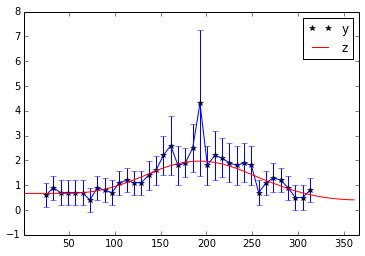

In [42]:
# and test it on a new pixel

r = 472
c = 84

#r = 9
#c = 277
gamma = 5.

pixel = data[:,r,c]
pixel_sd =   sd[:,r,c]

x = np.arange(46)*8+1

order = 2
# solve for gamma - degree of smoothness 
zz = smoothn(pixel,sd=pixel_sd,smoothOrder=2.0)
z = zz[0]
print zz[1],zz[2]

gamma = zz[1]

# plot
plt.plot(x,pixel,'k*',label='y')
plt.errorbar(x,pixel,pixel_sd*1.96)
plt.plot(x,z,'r',label='z')

plt.xlim(1,366)
plt.legend(loc='best')

To apply this approach to our 3D dataset, we could simply loop over all pixels.

Note that *any* per-pixel processing will be slow ... but this is quite a fast smoothing method, so is feasible here.

In [43]:
# we have put in an axis control to smoothn
# here so it will only smooth over doy
# This will take a few minutes to process
# we switch on verbose mode to get some feedback
# on progress

# make a mask of pixels where there is at least 1 sample
# over the time period
mask = (data.mask.sum(axis=0) == 0)
mask = np.array([mask]*data.shape[0])

z = smoothn(data,s=5.0,sd=sd,smoothOrder=2.0,axis=0,TolZ=0.05,verbose=True)[0]
z = ma.array(z,mask=mask)

tol 1.0 nit 0
tol 1.03767913976 nit 1
tol 0.695375818129 nit 2
tol 0.55340286659 nit 3
tol 0.379048609608 nit 4
tol 0.297133997656 nit 5
tol 0.211254020382 nit 6
tol 0.161703395437 nit 7
tol 0.118022633002 nit 8
tol 0.089141179031 nit 9
tol 0.0662378920796 nit 10


<matplotlib.colorbar.Colorbar instance at 0x7effe816f758>

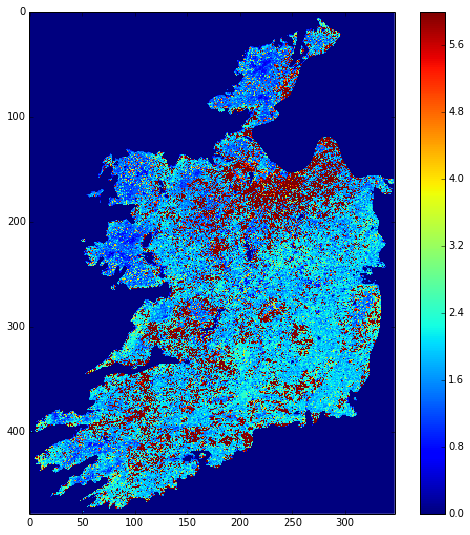

In [44]:
plt.figure(figsize=(9,9))
plt.imshow(z[20],interpolation='none',vmax=6)
plt.colorbar()

s = 0.731142059593


<matplotlib.colorbar.Colorbar instance at 0x7effdfe09c68>

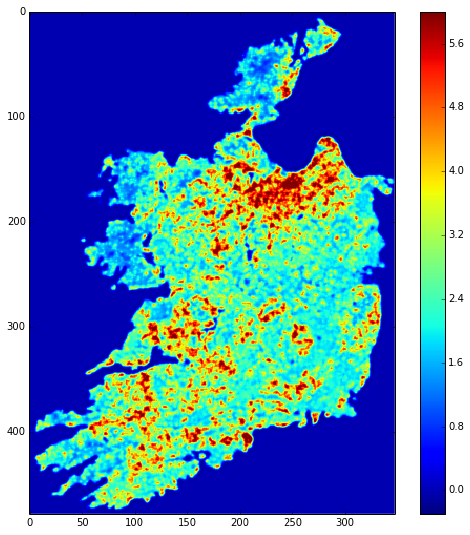

In [45]:
# similarly, take frame 20
# and smooth that

ZZ = smoothn(z[20],smoothOrder=2.)
# self-calibrated smoothness term
s = ZZ[1]
print 's =',s
Z = ZZ[0]
plt.figure(figsize=(9,9))
plt.imshow(Z,interpolation='none',vmax=6)
plt.colorbar()

tol 1.0 nit 0


<matplotlib.colorbar.Colorbar instance at 0x7effdff0e050>

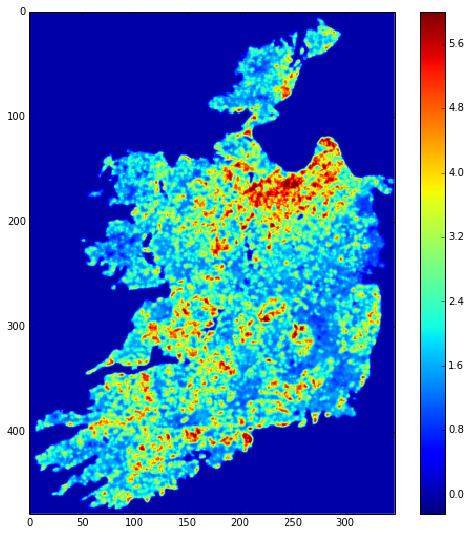

In [46]:
# similarly, take frame 20
# and smooth that

ZZ = smoothn(z,s=s,smoothOrder=2.,axis=(1,2),verbose=True)

Z = ZZ[0]
plt.figure(figsize=(9,9))
plt.imshow(Z[30],interpolation='none',vmax=6)
plt.colorbar()

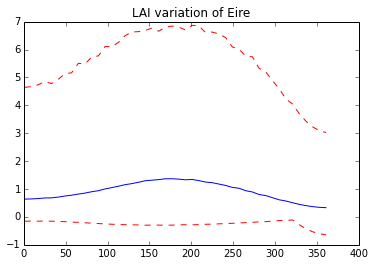

In [47]:
x = np.arange(46)*8+1.
try:
    plt.plot(x,np.mean(Z,axis=(1,2)))
    plt.plot(x,np.min(Z,axis=(1,2)),'r--')
    plt.plot(x,np.max(Z,axis=(1,2)),'r--')
except:
    plt.plot(x,np.mean(Z,axis=2).mean(axis=1))
    plt.plot(x,np.min(Z,axis=2).min(axis=1),'r--')
    plt.plot(x,np.max(Z,axis=2).max(axis=1),'r--')
    
plt.title('LAI variation of Eire')

In [48]:
# or doing this pixel by pixel ...
# which is slower than using axis

order = 2

# pixels that have some data
mask = (~data.mask).sum(axis=0)

odata = np.zeros((46,) + mask.shape)

rows,cols = np.where(mask>0)

len_x = len(rows)
order = 2
gamma = 5.

for i in xrange(len_x):
    r,c = rows[i],cols[i]
    # progress bar
    if i%(len_x/20) == 0:
        print '... %4.2f percent'%(i*100./float(len_x))
    pixel    = data[:,r,c]
    pixel_sd = sd[:,r,c]

    zz = smoothn(pixel,s=gamma,sd=pixel_sd,smoothOrder=order,TolZ=0.05)
    odata[:,rows[i],cols[i]] = zz[0]


... 0.00 percent
... 5.00 percent
... 10.00 percent
... 15.00 percent
... 20.00 percent
... 25.00 percent
... 30.00 percent
... 35.00 percent
... 40.00 percent
... 45.00 percent
... 50.00 percent
... 55.00 percent
... 60.00 percent
... 65.00 percent
... 70.00 percent
... 75.00 percent
... 80.00 percent
... 85.00 percent
... 90.00 percent
... 95.00 percent


In [49]:
import pylab as plt
import os

root = 'images/lai_eire_colourZ'

for i,f in enumerate(lai['filenames']):
    fig = plt.figure(figsize=(7,7))
    # get some info from filename
    file_id = f.split('/')[-1].split('.')[-5][1:]
    print file_id
    plt.imshow(Z[i],interpolation='none',vmax=6.,vmin=0.0)
    # plot a jpg
    plt.title(file_id)
    plt.colorbar()
    plt.savefig('%s_%s.jpg'%(root,file_id))
    plt.close(fig)

2005001
2005009
2005017
2005025
2005033
2005041
2005049
2005057
2005065
2005073
2005081
2005089
2005097
2005105
2005113
2005121
2005129
2005137
2005145
2005153
2005161
2005169
2005177
2005185
2005193
2005201
2005209
2005217
2005225
2005233
2005241
2005249
2005257
2005265
2005273
2005281
2005289
2005297
2005305
2005313
2005321
2005329
2005337
2005345
2005353
2005361


In [50]:
cmd = 'convert -delay 100 -loop 0 {0}_*.jpg {0}_movie2.gif'.format(root)
os.system(cmd)

0

![](files/images/lai_eire_colourZ_movie2.gif)

### 5.3 Function fitting

Sometimes, instead of applying some arbitrary smoothing function to data, we want to extract particular infromation from the time series.

One way to approach this is to fit some function to the time series at each location.

Let us suppose that we wish to characterise the phenology of vegetation in Ireland.

![](http://www2.geog.ucl.ac.uk/~plewis/geogg124/_images/zhang1.png)

One way we could do this would be to look in the lai data for the most rapid changes.

Another would be to explicitly fit some mathematical function to the LAI data that would would expect to descrive typical LAI trajectories.

One example of such a function is the double logistic. A logistic function is:

$$
 \hat{y} = p_0 - p_1 \left( \frac{1}{1 + e^{p_2 (t - p_3)}} + \frac{1}{1 + e^{p_4 (t - p_5)}} -1\right)
$$




We can give a function for a double logistic:

In [53]:
def dbl_logistic_model ( p, t ):
        """A double logistic model, as in Sobrino and Juliean, 
        or Zhang et al"""
        return p[0] - p[1]* ( 1./(1+np.exp(p[2]*(t-p[3]))) + \
                              1./(1+np.exp(-p[4]*(t-p[5])))  - 1 )
   

In [54]:
tile = 'h17v03'
year = '2005'

# specify the file with the urls in
ifile= 'data/modis_lai_%s_%s.txt'%(tile,year)

fp = open(ifile)
filelist = [url.split('/')[-1].strip() for url in fp.readlines()]
fp.close()
import sys
sys.path.insert(0,'python')

from get_lai import *

try:
    data = lai['Lai_1km']
    sd = lai['LaiStdDev_1km']
except:
    lai = read_lai(filelist,country='IRELAND')
    data = lai['Lai_1km']
    sd = lai['LaiStdDev_1km']
    
thresh = 0.25
sd[sd<thresh] = thresh

# test pixel
r = 472
c = 84


y = data[:,r,c]
mask = ~y.mask
y = np.array(y[mask])
x = (np.arange(46)*8+1.)[mask]
unc = np.array(sd[:,r,c][mask])

And see what this looks like:

<Container object of 3 artists>

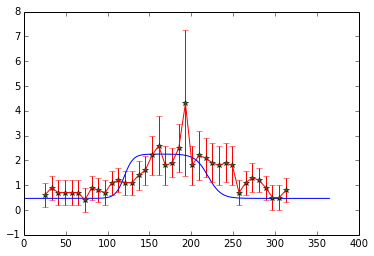

In [55]:
# define x (time)
x_full = np.arange(1,366) 

# some default values for the parameters
p = np.zeros(6)

# some stats on y
ysd = np.std(y)
ymean = np.mean(y)

# some rough guesses at the parameters

p[0] = ymean - 1.151*ysd;   # minimum  (1.151 is 75% CI)
p[1] = 2*1.151*ysd          # range
p[2] = 0.19                 # related to up slope
p[3] = 120                  # midpoint of up slope
p[4] = 0.13                 # related to down slope
p[5] = 220                  # midpoint of down slope

y_hat = dbl_logistic_model(p,x_full)

plt.clf()
plt.plot(x_full,y_hat)
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)

We could manually 'tweak' the parameters until we got a better 'fit' to the observations.

First though, let's define a measure of 'fit':

$$
Z_i = \frac{\hat{y}_i - y_i}{\sigma_i}
$$

$$
Z^2 = \sum_i{Z_i^2} =  \sum_i{\left( \frac{\hat{y}_i - y_i}{\sigma_i} \right)^2}
$$

and implement this as a mismatch function where we have data points:

Z^2 = 113.325251358


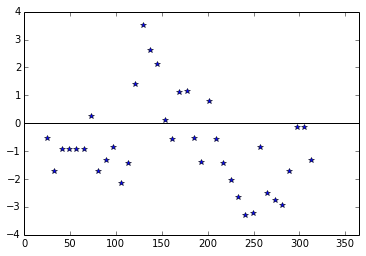

In [56]:
def mismatch_function(p, x, y, unc):
    y_hat = dbl_logistic_model(p, x)
    diff = (y_hat - y)/unc
    return diff


Z = mismatch_function(p,x,y,unc)

plt.plot([1,365.],[0,0.],'k-')
plt.xlim(0,365)
plt.plot(x,Z,'*')


print 'Z^2 =',(Z**2).sum()

Now lets change p a bit:

Z^2 = 105.478274642


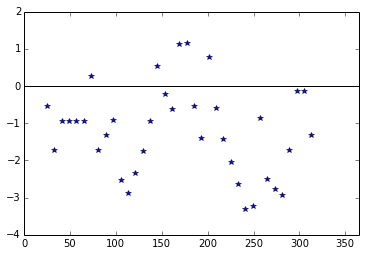

In [57]:
p[0] = ymean - 1.151*ysd;   # minimum  (1.151 is 75% CI)
p[1] = 2*1.151*ysd          # range
p[2] = 0.19                 # related to up slope
p[3] = 140                  # midpoint of up slope
p[4] = 0.13                 # related to down slope
p[5] = 220                  # midpoint of down slope

Z = mismatch_function(p,x,y,unc)

plt.plot([1,365.],[0,0.],'k-')
plt.xlim(0,365)
plt.plot(x,Z,'*')


print 'Z^2 =',(Z**2).sum()

We have made the mismatch go down a little ...

Clearly it would be tedious (and impractical) to do a lot of such tweaking, so we can use methods that seek the minimum of some function.

One such method is implemented in `scipy.optimize.leastsq`:

initial parameters: 0.468054306457 1.78821571141 0.19 140.0 0.13 220.0
23.2758024553
solved parameters:  0.615259703304 2.86129713068 0.035948726095 158.837861729 0.0384066709502 227.612228424
phenology 158.837861729 68.7743666946


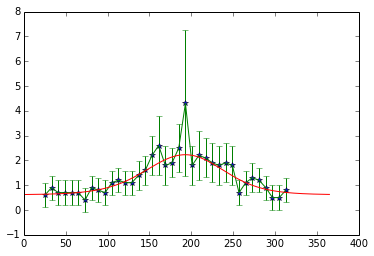

In [58]:
from scipy import optimize

# initial estimate is in p
print 'initial parameters:',p[0],p[1],p[2],p[3],p[4],p[5]

# set some bounds for the parameters
bound = np.array([(0.,10.),(0.,10.),(0.01,1.),\
                  (50.,300.),(0.01,1.),(50.,300.)])


# test pixel
r = 472
c = 84


y = data[:,r,c]
mask = ~y.mask
y = np.array(y[mask])
x = (np.arange(46)*8+1.)[mask]
unc = np.array(sd[:,r,c][mask])

# define function to give Z^2

def sse(p,x,y,unc):
    '''Sum of squared error'''
    # penalise p[3] > p[5]
    err = np.max([0.,(p[3] - p[5])])*1e4
    return (mismatch_function(p,x,y,unc)**2).sum()+err

# we pass the function:
#
# sse               : the name of the function we wrote to give 
#                     sum of squares of Z_i
# p                 : an initial estimate of the parameters
# args=(x,y,unc)    : the other information (other than p) that
#                     mismatch_function needs
# approx_grad       : if we dont have a function for the gradien
#                     we have to get the solver to approximate it
#                     which takes time ... see if you can work out
#                     d_sse / dp and use that to speed this up!

psolve = optimize.fmin_l_bfgs_b(sse,p,approx_grad=True,iprint=-1,\
                                args=(x,y,unc),bounds=bound)

print psolve[1]
pp = psolve[0]
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)
y_hat = dbl_logistic_model(pp,x_full)
plt.plot(x_full,y_hat)

print 'solved parameters: ',pp[0],pp[1],pp[2],pp[3],pp[4],pp[5]

# if we define the phenology as the parameter p[3]
# and the 'length' of the growing season:
print 'phenology',pp[3],pp[5]-pp[3]

In [ ]:
# and run over each pixel ... this will take some time

# pixels that have some data
mask = (~data.mask).sum(axis=0)

pdata = np.zeros((7,) + mask.shape)

rows,cols = np.where(mask>0)
len_x = len(rows)

# lets just do some random ones to start with
#rows = rows[::10]
#cols = cols[::10]

len_x = len(rows)


for i in xrange(len_x):
    r,c = rows[i],cols[i]
    # progress bar
    if i%(len_x/40) == 0:
        print '... %4.2f percent'%(i*100./float(len_x))
    
    y = data[:,r,c]
    mask = ~y.mask
    y = np.array(y[mask])
    x = (np.arange(46)*8+1.)[mask]
    unc = np.array(sd[:,r,c][mask])
    
    # need to get an initial estimate of the parameters
    
    # some stats on y
    ysd = np.std(y)
    ymean = np.mean(y)

    p[0] = ymean - 1.151*ysd;   # minimum  (1.151 is 75% CI)
    p[1] = 2*1.151*ysd          # range
    p[2] = 0.19                 # related to up slope
    p[3] = 140                  # midpoint of up slope
    p[4] = 0.13                 # related to down slope
    p[5] = 220                  # midpoint of down slope

    
    # set factr to quite large number (relative error in solution)
    # as it'll take too long otherwise
    psolve = optimize.fmin_l_bfgs_b(sse,p,approx_grad=True,iprint=-1,\
                                args=(x,y,unc),bounds=bound,factr=1e12)

    pdata[:-1,rows[i],cols[i]] = psolve[0]
    pdata[-1,rows[i],cols[i]] = psolve[1] # sse


... 0.00 percent
... 2.50 percent
... 5.00 percent

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(pdata[3],interpolation='none',vmin=137,vmax=141)
plt.title('green up doy')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(pdata[5]-pdata[3],interpolation='none',vmin=74,vmax=84)
plt.title('season length')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(pdata[0],interpolation='none',vmin=0.,vmax=6.)
plt.title('min LAI')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(pdata[1]+pdata[0],interpolation='none',vmin=0.,vmax=6.)
plt.title('max LAI')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(pdata[-1]),interpolation='none',vmax=np.sqrt(500))
plt.title('RSSE')
plt.colorbar()

In [ ]:
# check a few pixels

c = 200

for r in xrange(200,400,25):
    y = data[:,r,c]
    mask = ~y.mask
    y = np.array(y[mask])
    x = (np.arange(46)*8+1.)[mask]
    unc = np.array(sd[:,r,c][mask])
    
    x_full = np.arange(1,366) 
    
    # some default values for the parameters
    pp = pdata[:-1,r,c]
    plt.figure(figsize=(7,7))
    plt.title('r %d c %d'%(r,c))
    plt.plot(x,y,'*')
    plt.errorbar(x,y,unc*1.96)
    y_hat = dbl_logistic_model(pp,x_full)
    plt.plot(x_full,y_hat)
    
    print 'solved parameters: ',pp[0],pp[1],pp[2],pp[3],pp[4],pp[5]
    
    # if we define the phenology as the parameter p[3]
    # and the 'length' of the growing season:
    print 'phenology',pp[3],pp[5]-pp[3]